##### Feature selection using sklearn not needed

In [94]:
from sklearn.feature_selection import SelectKBest, f_regression,  f_classif

In [46]:
features = SelectKBest(f_regression,k=6).fit(data.drop(columns=['home_win','home_margin']), data['home_margin']).get_feature_names_out()

In [48]:
s = setup(data[features].join(data['home_margin']), target = 'home_margin', session_id = 123)

In [47]:
print(features)

['home_blocks' 'away_blocks' 'home_turnovers' 'away_turnovers'
 'comp_rate_diff' 'block_turnover_diff']


In [95]:
features = SelectKBest(f_classif,k='all').fit(data.drop(columns=['home_win','home_margin']), data['home_win'])

In [96]:
features.get_feature_names_out()

array(['home_completions', 'away_completions', 'home_throws',
       'away_throws', 'home_blocks', 'away_blocks', 'home_turnovers',
       'away_turnovers', 'home_completion_rate', 'away_completion_rate',
       'comp_rate_diff', 'block_turnover_diff'], dtype=object)

In [97]:
features

SelectKBest(k='all', score_func=<function f_classif at 0x000001C26FB7E560>)

In [100]:
pd.DataFrame(features.scores_, index=features.get_feature_names_out()).sort_values(0,ascending=False)

0
block_turnover_diff   1714.039447
comp_rate_diff         372.950101
away_blocks            281.489295
home_blocks            245.315411
away_turnovers         205.624897
home_turnovers         198.546281
home_completion_rate   129.430508
away_completion_rate    76.685462
home_completions         1.554396
away_completions         1.395838
away_throws              0.882947
home_throws              0.679087

---

##### I/O for Regression Results

*save all regression experiment results as JSON, no longer need to rerun!!!*

see cells for examples on loading, and serializing JSON before saving to file

---

In [91]:
import json
print('all regression and classification results complete, store locally')

all regression and classification results complete, store locally


In [92]:
results_dump = {}
for key,val in classification_results.items(): # regression data stored as "results", not "classification_results"
    results_dump[key] = val.to_json()

In [93]:
with open('pycaret_classification_results.json', 'w') as f:
    f.write(json.dumps(results_dump))

In [69]:
with open('pycaret_regression_results.json', 'r') as f:
    test = json.load(f)

In [71]:
test2 = {}
for key,val in test.items():
    test2[key] = pd.read_json(val)

----

### PyCaret

##### Notes


*use Python 3.10 virtual environment*

- use for model selection: ~~preprocessing, training, tuning, interpretation~~
  - use entire dataset for evaluation
  - given automated nature, try for regression `home_margin` and binary classification `home_win`
- links
  - [Getting Startted Tutorials](https://pycaret.gitbook.io/docs/get-started/tutorials)
  - [API reference](https://pycaret.readthedocs.io/en/latest/index.html)
- helpful (after importing a regression or classification experiment)
  - `help(plot_model)`

##### Conclusions

 - **great utility for initial model selection**
   - streamline in future by:
     - loop over different "experiments" to test various data treaments (feature selection, normalization)
     - or figure out how to integrate within experiment setup
 - **default model tuning needs increased iterations**
   - further tuning studies performed in a separate notebook
     - 60 iterations sufficient for time/performance tradeoff for ensemble models
     - 90 iterations typically enough to maximize performance for linear models and those that are faster cross-validate
   - some models don't improve even with increased iterations, custom hyperparameter grid could be worth trying?
     - *regression*: `CatBoost, ET, LAR, Bayesian Ridge`
     - *classification*: `RF, ET, LDA, NB (minor improvement)`
 - **Future**
   - *Evaluate Auto-EDA functions in future PyCaret explorations, try automating Kaggle challenges*

---



### Start
 - load data
 - drop descriptive features
 - utilize entire dataset for model selection studies
   - feature selection and normalization tested for both regression (`home_margin`) and classiciation (`home_win`)

<font color=red>To Do
<br>• read up on metrics and provide analysis for results
</font>

 - metric reading links
   - https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification
   - https://scikit-learn.org/stable/modules/model_evaluation.html
   - see course readings . . . 
     - `C:\Users\Nish\Classes\springboard\18 - Model Evaluation`

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)

In [3]:
import pycaret
pycaret.__version__

'3.1.0'

In [4]:
d = pd.read_parquet('data/game_stats.parquet')
d.shape

(1521, 20)

In [5]:
data = d.iloc[:,6:]
data.sample(2).T

1544      2693
home_completions           185       259
away_completions           307       296
home_throws                209       279
away_throws                327       320
home_blocks                  7        12
away_blocks                 14        12
home_turnovers              24        20
away_turnovers              20        24
home_completion_rate  0.885167  0.928315
away_completion_rate  0.938838     0.925
comp_rate_diff        -0.05367  0.003315
block_turnover_diff        -11         4
home_win                 False      True
home_margin                 -5         4

### Regression
- experiment parameters [api ref](https://pycaret.readthedocs.io/en/latest/api/regression.html)
  - test effects of feature_selection and normalizing on `compare_models`
- based on results, can then use `create_model` and tune
- test `evaluate_model` and `interpret_model` functions with **best**

```
train_size=0.8 
normalize=True # try both
feature_selection=True, n_features_to_select=6, # try with on and off

    # maybe later
fold = 10 (default) # could reduce. could stratify (data_split_stratify)
??? preprocess=False, custom_pipeline/custom_pipeline_position ???
polynomial_features=True, group_features=True, remove_multicollinearity=True, remove_outliers=True, transformation=True
```

In [6]:
results = {}

##### Regression Results
 - **TWO TUNING PIPELINES - ensemble (with Huber) + linear (with KNN)**
   - no treatment of data for ensemble, ~~scale and ~~feature select for linear
 - . . .notes. . .
   - for best performing **ensemble models** (`gb, lgbm, rf, et`)
     - normalization provides marginal improvement
       - decreases performance for other models (lar, adaboost)
     - feature selection reduces performance
       - brings `KNN` into relevance
   - **linear models** (`ridge, lasso, lr, elastic net, huber`)
     - feature selection 
       - improves some: lr, ridge, br, lar
       - hurts others: elastic net, lasso
     - for ones with performance increase with feature selection, additional normalization does not help 

In [38]:
# manual vmax for background gradients due to extremely (bad) LAR results for all data, normalized

for key,val in results.items():
    print(key)
    display(val.sort_values('R2',ascending=False).style\
            .background_gradient(subset=['R2'], cmap='viridis', vmin=np.percentile(val.R2, 0.5))
            .background_gradient(subset=['MAE'], cmap='viridis_r', vmax=5)
            .background_gradient(subset=['RMSE'], cmap='viridis_r', vmax=7)
            .background_gradient(subset=['MAPE'], cmap='viridis_r', vmax=1)
            .highlight_max(subset=['R2'],  props='font-weight:bold')
            .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))

all data, no scaling


select 6, no scaling


all data, zscore normalized


select 6, zscore normalized


In [41]:
for key,val in results.items():
    print(key)
    val = val[(val.Model.str.endswith('Regression')) | (val.Model.str.endswith('Ridge'))| (val.Model.str.endswith('Net'))| (val.Model.str.startswith('Huber'))]
    display(val.sort_values('R2',ascending=False).style\
            .background_gradient(subset=['R2'], cmap='viridis')
            .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
            .highlight_max(subset=['R2'],  props='font-weight:bold')
            .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))

all data, no scaling


select 6, no scaling


all data, zscore normalized


select 6, zscore normalized


all data, no scaling


Model    MAE     MSE   RMSE     R2  RMSLE  \
gbr           Gradient Boosting Regressor  1.788   7.609  2.678  0.864  0.419   
lightgbm  Light Gradient Boosting Machine  1.799   7.756  2.700  0.862  0.435   
et                  Extra Trees Regressor  1.848   8.083  2.755  0.856  0.447   
rf                Random Forest Regressor  1.891   8.740  2.856  0.844  0.438   
en                            Elastic Net  1.923   9.377  2.945  0.832  0.454   
br                         Bayesian Ridge  1.825   9.457  2.926  0.830  0.440   
ridge                    Ridge Regression  1.821   9.502  2.931  0.829  0.439   
lasso                    Lasso Regression  1.994   9.499  2.981  0.829  0.461   
llar         Lasso Least Angle Regression  1.995   9.501  2.981  0.829  0.462   
lar                Least Angle Regression  1.822   9.526  2.935  0.829  0.439   
lr                      Linear Regression  1.828   9.560  2.940  0.828  0.440   
omp           Orthogonal Matching Pursuit  2.172   9.906  3.085  0.820  0.495   
huber                     Huber Regressor  1.529  11.217  3.099  0.796  0.360   
ada                    AdaBoost Regressor  2.531  12.167  3.446  0.778  0.521   
dt                Decision Tree Regressor  2.691  17.076  3.990  0.696  0.531   
knn                 K Neighbors Regressor  3.230  19.675  4.413  0.639  0.646   
par          Passive Aggressive Regressor  3.549  23.632  4.361  0.576  0.661   
dummy                     Dummy Regressor  5.764  54.948  7.398 -0.005  1.026   

           MAPE  TT (Sec)  
gbr       0.540     0.048  
lightgbm  0.546     0.065  
et        0.552     0.061  
rf        0.567     0.123  
en        0.570     0.008  
br        0.543     0.008  
ridge     0.542     0.008  
lasso     0.588     0.242  
llar      0.588     0.009  
lar       0.543     0.008  
lr        0.545     0.501  
omp       0.649     0.008  
huber     0.475     0.014  
ada       0.796     0.028  
dt        0.816     0.009  
knn       0.796     0.013  
par       1.172     0.008  
dummy     1.052     0.007

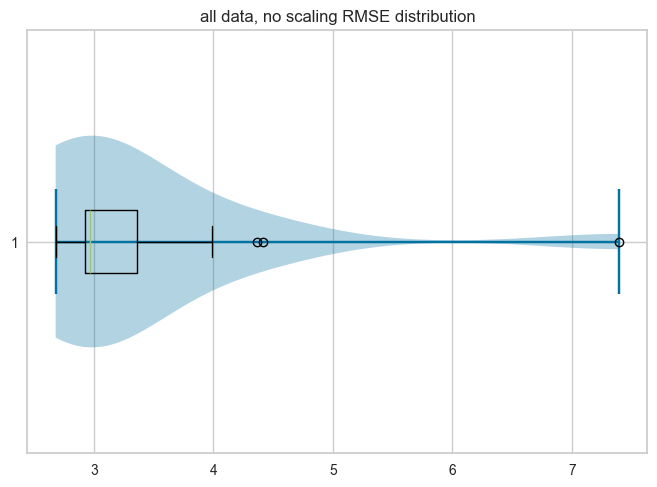

select 6, no scaling


Model    MAE     MSE   RMSE     R2  RMSLE  \
knn                 K Neighbors Regressor  1.764   7.923  2.704  0.859  0.407   
gbr           Gradient Boosting Regressor  1.863   8.062  2.756  0.856  0.433   
et                  Extra Trees Regressor  1.852   8.160  2.760  0.854  0.443   
lightgbm  Light Gradient Boosting Machine  1.873   8.791  2.860  0.843  0.450   
rf                Random Forest Regressor  1.922   9.297  2.941  0.835  0.442   
ridge                    Ridge Regression  1.828   9.346  2.914  0.832  0.438   
lr                      Linear Regression  1.832   9.349  2.916  0.832  0.440   
lar                Least Angle Regression  1.828   9.349  2.916  0.832  0.440   
br                         Bayesian Ridge  1.840   9.431  2.930  0.830  0.441   
en                            Elastic Net  1.931   9.470  2.960  0.830  0.450   
lasso                    Lasso Regression  2.014   9.670  3.008  0.826  0.461   
llar         Lasso Least Angle Regression  2.014   9.671  3.008  0.826  0.461   
omp           Orthogonal Matching Pursuit  2.172   9.906  3.085  0.820  0.495   
huber                     Huber Regressor  1.533  11.410  3.119  0.793  0.365   
ada                    AdaBoost Regressor  2.654  13.297  3.609  0.756  0.547   
dt                Decision Tree Regressor  2.749  17.551  4.076  0.685  0.545   
par          Passive Aggressive Regressor  2.882  19.444  4.074  0.632  0.566   
dummy                     Dummy Regressor  5.764  54.948  7.398 -0.005  1.026   

           MAPE  TT (Sec)  
knn       0.520     0.013  
gbr       0.558     0.029  
et        0.567     0.052  
lightgbm  0.569     0.062  
rf        0.585     0.075  
ridge     0.542     0.009  
lr        0.543     0.194  
lar       0.541     0.010  
br        0.546     0.010  
en        0.567     0.008  
lasso     0.589     0.133  
llar      0.589     0.011  
omp       0.649     0.009  
huber     0.481     0.013  
ada       0.825     0.024  
dt        0.836     0.010  
par       0.795     0.010  
dummy     1.052     0.009

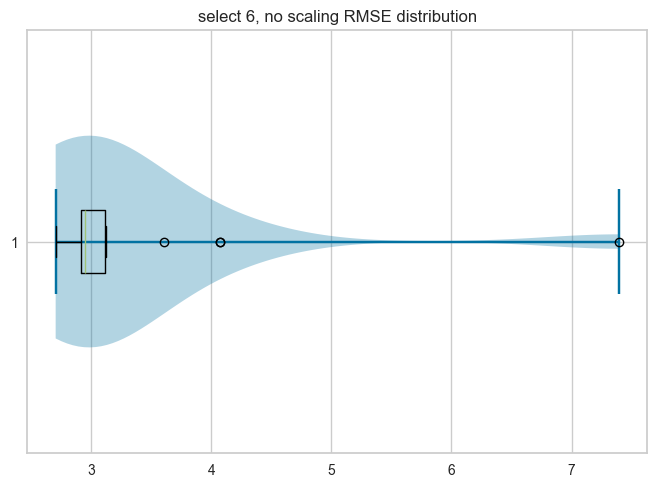

all data, zscore normalized


Model       MAE           MSE      RMSE  \
gbr           Gradient Boosting Regressor     1.785  7.598000e+00     2.676   
lightgbm  Light Gradient Boosting Machine     1.782  7.708000e+00     2.689   
et                  Extra Trees Regressor     1.848  8.083000e+00     2.755   
rf                Random Forest Regressor     1.898  8.781000e+00     2.864   
ridge                    Ridge Regression     1.837  9.494000e+00     2.935   
br                         Bayesian Ridge     1.842  9.504000e+00     2.938   
lr                      Linear Regression     1.828  9.560000e+00     2.940   
omp           Orthogonal Matching Pursuit     2.172  9.906000e+00     3.085   
lasso                    Lasso Regression     2.347  1.090700e+01     3.259   
llar         Lasso Least Angle Regression     2.347  1.090700e+01     3.259   
knn                 K Neighbors Regressor     2.231  1.100500e+01     3.264   
huber                     Huber Regressor     1.534  1.126500e+01     3.108   
ada                    AdaBoost Regressor     2.545  1.244900e+01     3.482   
en                            Elastic Net     2.655  1.349500e+01     3.638   
dt                Decision Tree Regressor     2.702  1.713500e+01     3.998   
par          Passive Aggressive Regressor     2.499  1.662600e+01     3.895   
dummy                     Dummy Regressor     5.764  5.494800e+01     7.398   
lar                Least Angle Regression  6162.428  2.463776e+08  7553.232   

                   R2  RMSLE      MAPE  TT (Sec)  
gbr             0.864  0.418     0.539     0.047  
lightgbm        0.863  0.434     0.543     0.072  
et              0.856  0.447     0.552     0.063  
rf              0.843  0.438     0.568     0.126  
ridge           0.830  0.441     0.548     0.012  
br              0.829  0.443     0.549     0.010  
lr              0.828  0.440     0.545     0.010  
omp             0.820  0.495     0.649     0.010  
lasso           0.802  0.519     0.612     0.010  
llar            0.802  0.519     0.612     0.009  
knn             0.801  0.489     0.594     0.014  
huber           0.796  0.363     0.477     0.015  
ada             0.773  0.523     0.800     0.028  
en              0.756  0.567     0.597     0.009  
dt              0.694  0.533     0.819     0.011  
par             0.693  0.505     0.719     0.010  
dummy          -0.005  1.026     1.052     0.009  
lar      -4919107.314  2.629  2082.026     0.010

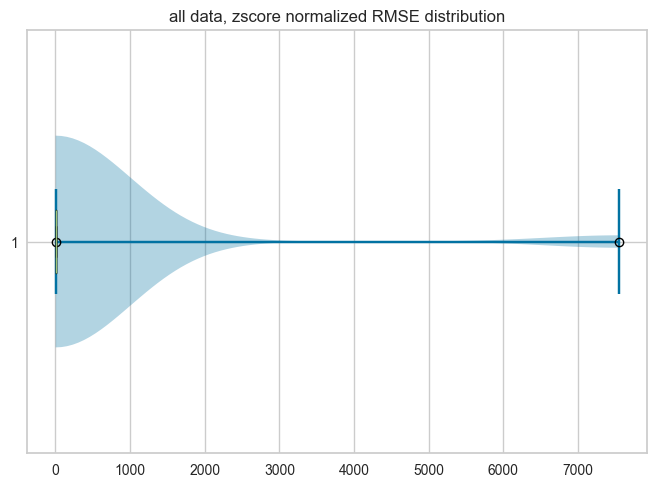

select 6, zscore normalized


Model    MAE     MSE   RMSE     R2  RMSLE  \
gbr           Gradient Boosting Regressor  1.857   7.983  2.743  0.858  0.433   
et                  Extra Trees Regressor  1.852   8.160  2.760  0.854  0.443   
lightgbm  Light Gradient Boosting Machine  1.880   8.830  2.868  0.842  0.445   
rf                Random Forest Regressor  1.925   9.326  2.948  0.834  0.442   
lr                      Linear Regression  1.831   9.342  2.915  0.832  0.438   
ridge                    Ridge Regression  1.831   9.348  2.917  0.832  0.440   
lar                Least Angle Regression  1.828   9.349  2.916  0.832  0.440   
br                         Bayesian Ridge  1.832   9.351  2.917  0.832  0.440   
knn                 K Neighbors Regressor  1.996   9.455  3.008  0.830  0.466   
omp           Orthogonal Matching Pursuit  2.172   9.906  3.085  0.820  0.495   
lasso                    Lasso Regression  2.347  10.907  3.259  0.802  0.519   
llar         Lasso Least Angle Regression  2.347  10.907  3.259  0.802  0.519   
huber                     Huber Regressor  1.533  11.409  3.119  0.793  0.365   
ada                    AdaBoost Regressor  2.649  13.209  3.598  0.757  0.550   
en                            Elastic Net  2.675  13.679  3.661  0.753  0.570   
par          Passive Aggressive Regressor  2.299  14.776  3.639  0.729  0.486   
dt                Decision Tree Regressor  2.747  17.594  4.082  0.684  0.547   
dummy                     Dummy Regressor  5.764  54.948  7.398 -0.005  1.026   

           MAPE  TT (Sec)  
gbr       0.557     0.030  
et        0.567     0.053  
lightgbm  0.566     0.058  
rf        0.584     0.076  
lr        0.544     0.010  
ridge     0.542     0.010  
lar       0.542     0.010  
br        0.542     0.011  
knn       0.559     0.015  
omp       0.649     0.010  
lasso     0.612     0.011  
llar      0.612     0.010  
huber     0.481     0.010  
ada       0.823     0.026  
en        0.598     0.010  
par       0.733     0.010  
dt        0.835     0.010  
dummy     1.052     0.010

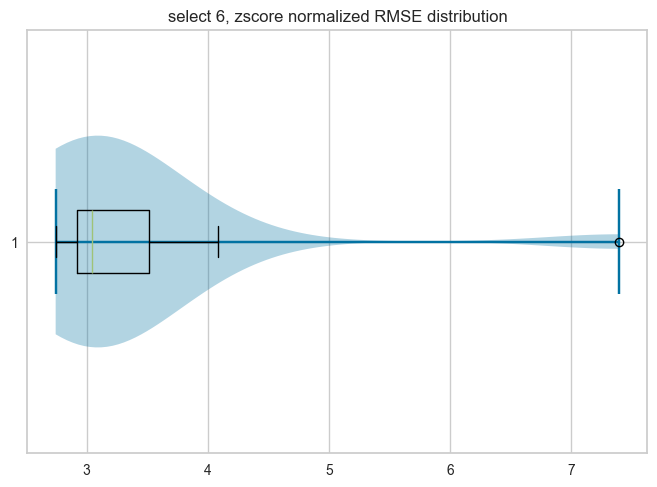

In [60]:
for key,val in results.items():
    print(key)
    display(val.sort_values('R2',ascending=False).round(3))
    plt.violinplot(val['RMSE'], vert=False)
    plt.boxplot(val['RMSE'], vert=False)
    plt.title(f'{key} RMSE distribution')
    plt.show()

#### All Numeric Data

In [7]:
from pycaret.regression import *
s1 = setup(data.drop(columns='home_win'), target = 'home_margin', session_id = 42,
           train_size=0.8)

In [8]:
# compare baseline models
best = compare_models()

In [9]:
results['all data, no scaling'] = pull()

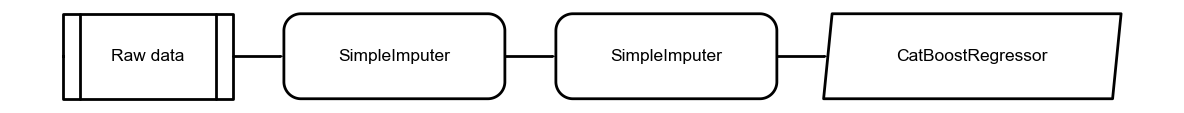

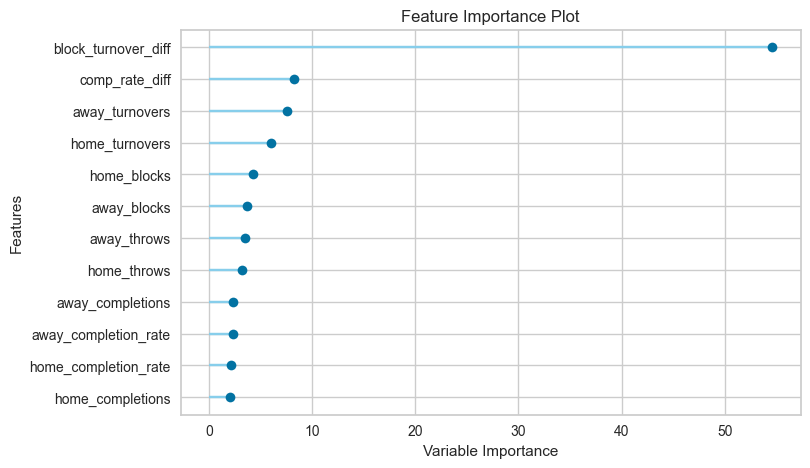

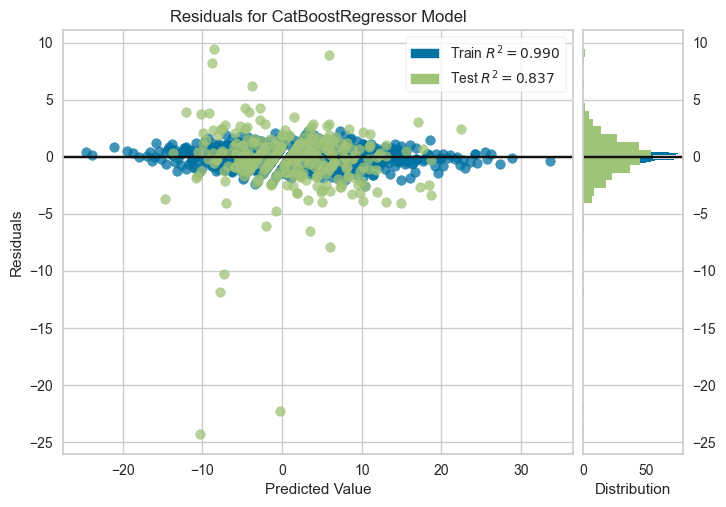

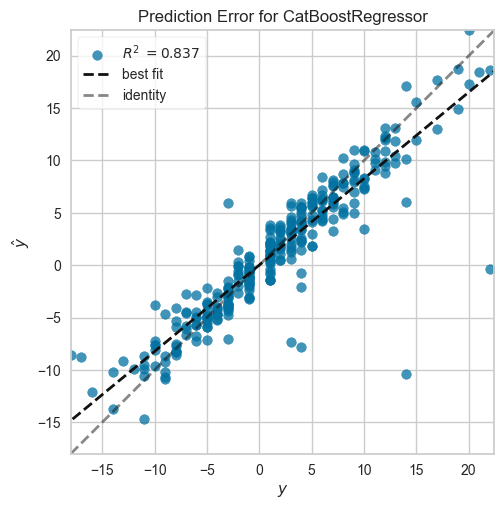

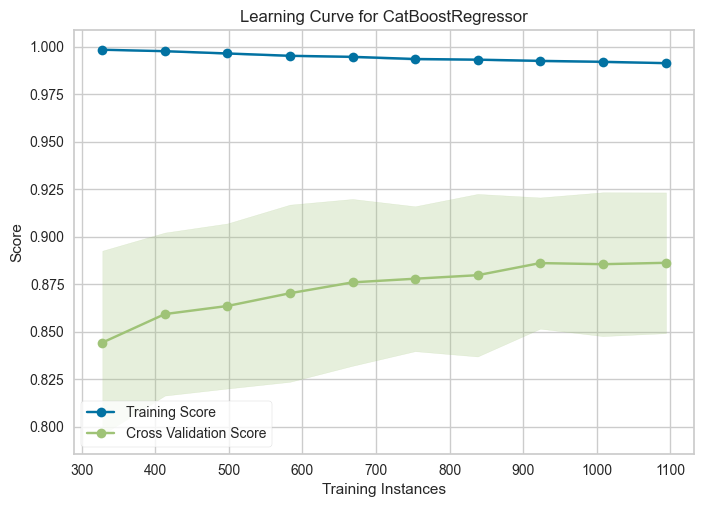

In [10]:
for plot_type in ['pipeline','feature_all','residuals', 'error', 'learning']:
    plot_model(best, plot=plot_type)

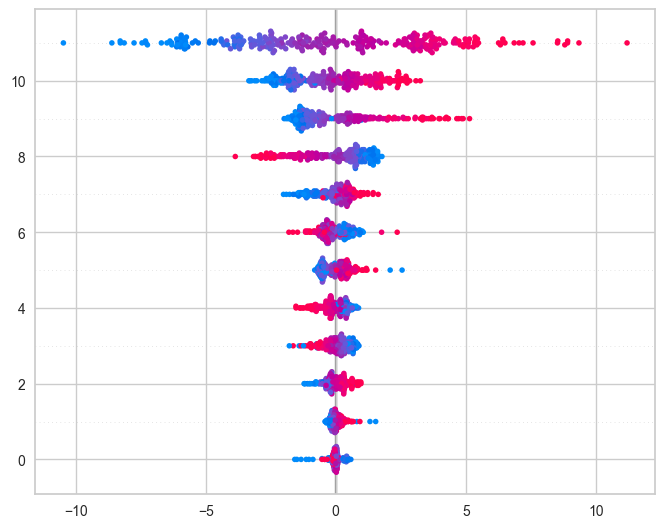

In [12]:
try:
    interpret_model(best)
except:
    pass

In [14]:
interpret_testing = create_model('lightgbm')

In [15]:
interpret_model(interpret_testing, plot='reason')

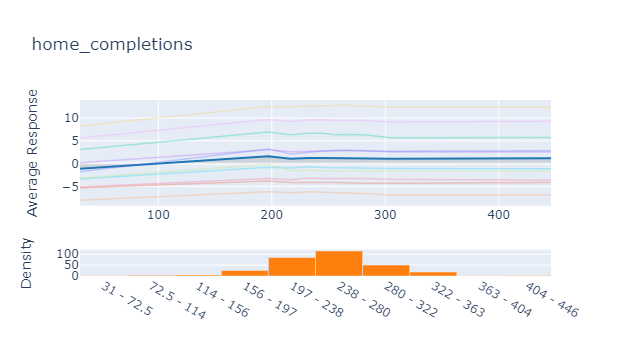

In [16]:
interpret_model(interpret_testing, plot='pdp')

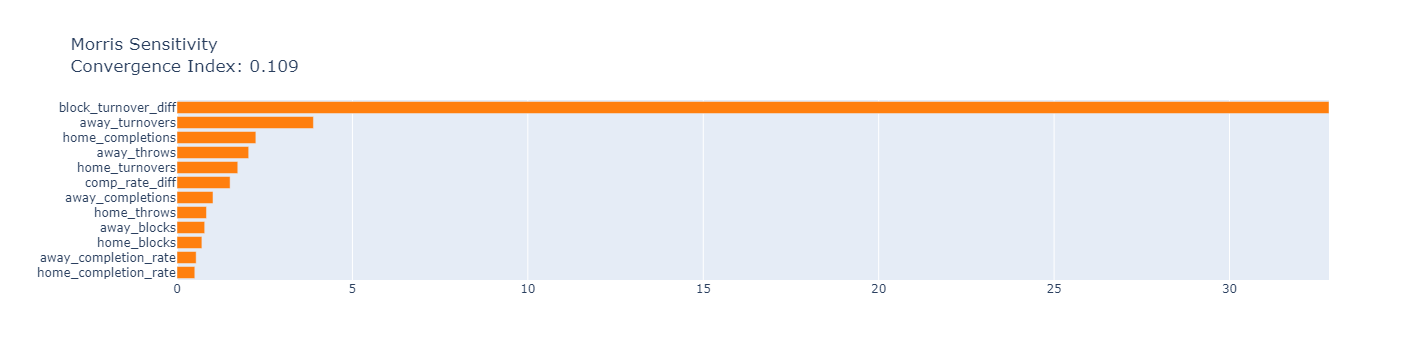

In [17]:
interpret_model(interpret_testing, plot='msa')

12it [00:00, 192.30it/s]


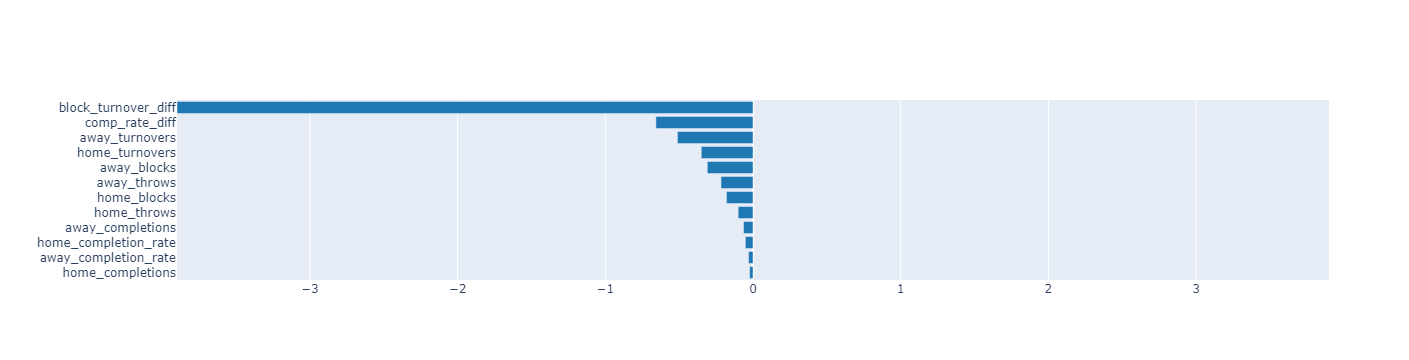

In [18]:
interpret_model(interpret_testing, plot='pfi')

#### Select 6 Features

##### setup

In [19]:
s2 = setup(data.drop(columns='home_win'), target = 'home_margin', session_id = 42, train_size=0.8,
          feature_selection=True, feature_selection_method='univariate', n_features_to_select=6)

In [21]:
# compare baseline models
best = compare_models()

In [22]:
results['select 6, no scaling'] = pull()

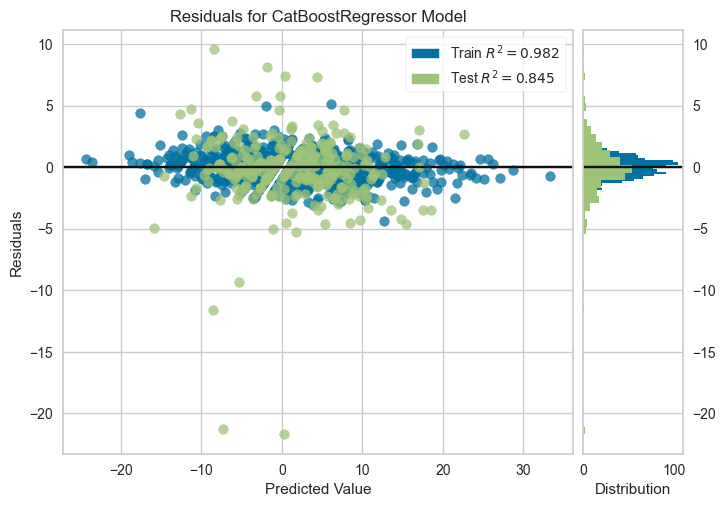

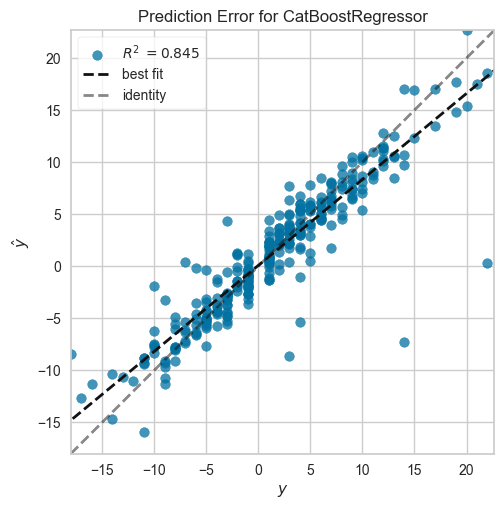

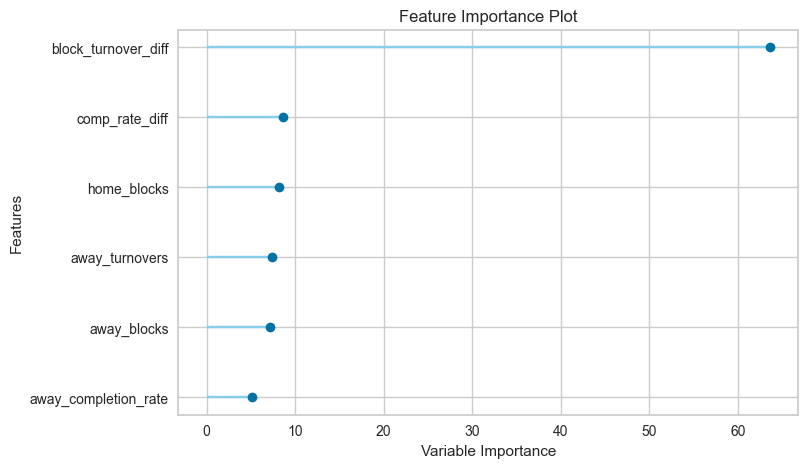

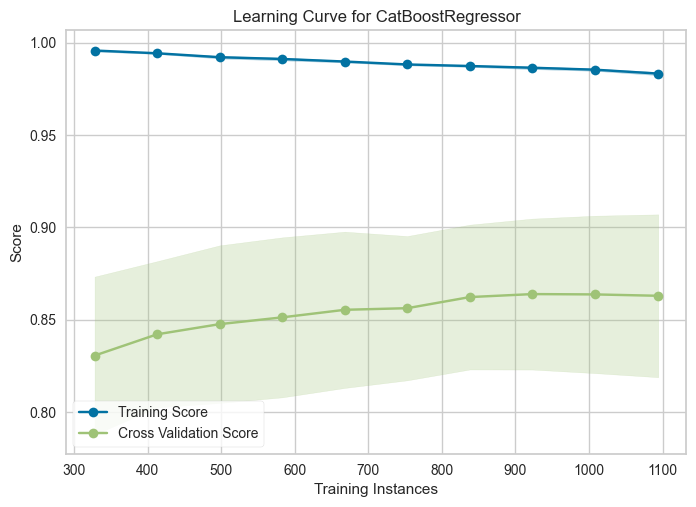

In [23]:
# evaluate best model
for plot_type in ['residuals', 'error', 'feature', 'learning']:
    try:
        plot_model(best, plot=plot_type)
    except:
        print(plot_type, 'not available')

#### Repeat above, scaled

In [24]:
s3 = setup(data.drop(columns='home_win'), target = 'home_margin', session_id = 42,
          train_size=0.8, normalize=True)

In [25]:
# compare baseline models
best = compare_models()

In [26]:
results['all data, zscore normalized'] = pull()

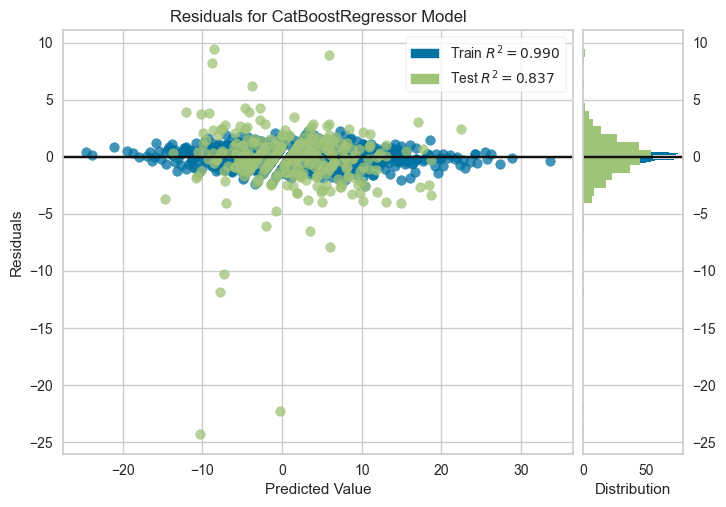

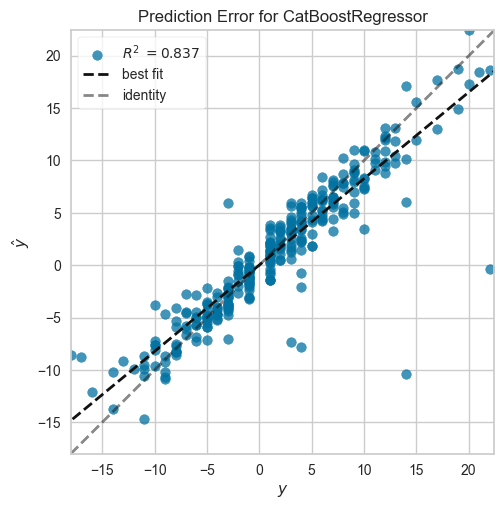

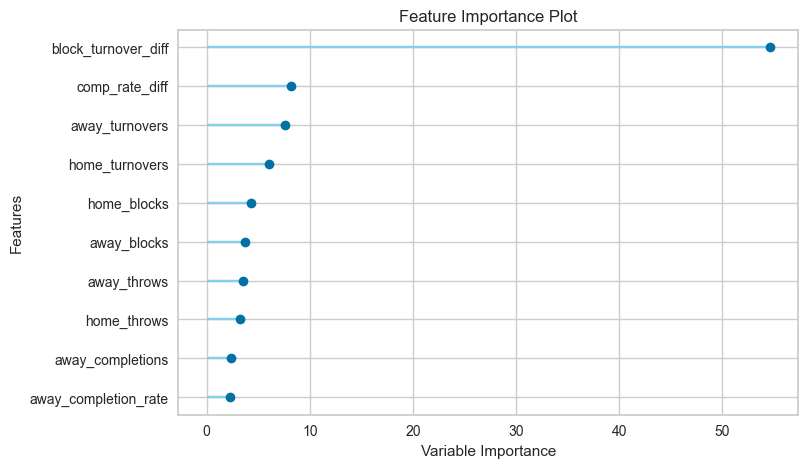

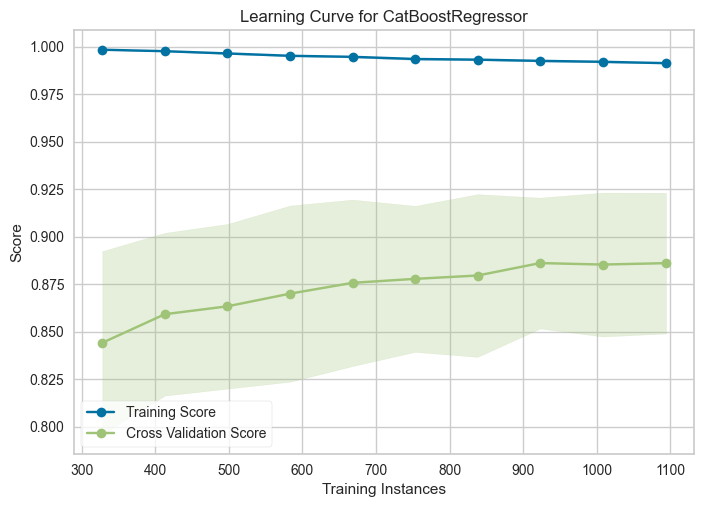

In [27]:
# evaluate best model
for plot_type in ['residuals', 'error', 'feature', 'learning']:
    try:
        plot_model(best, plot=plot_type)
    except:
        print(plot_type, 'plot not available for model')

In [28]:
s4 = setup(data.drop(columns='home_win'), target = 'home_margin', session_id = 42,  train_size=0.8,
          feature_selection=True, feature_selection_method='univariate', n_features_to_select=6,
          normalize=True)

In [29]:
# compare baseline models
best = compare_models()

In [30]:
results['select 6, zscore normalized'] = pull()

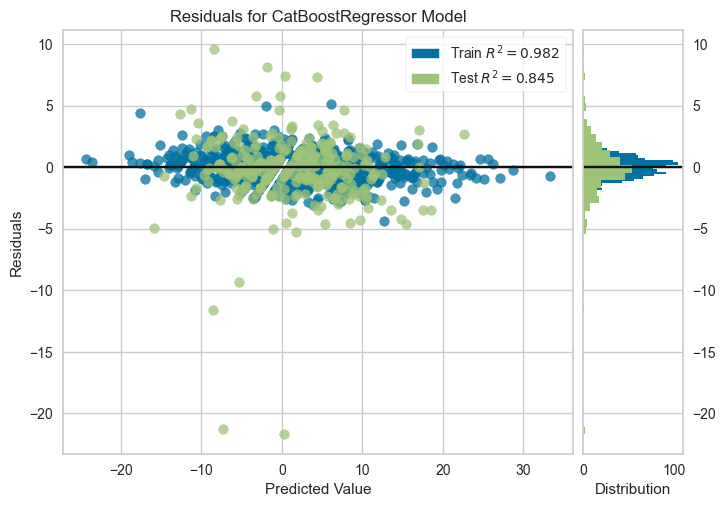

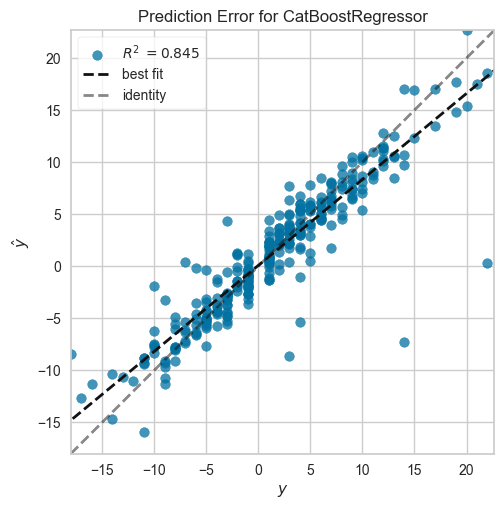

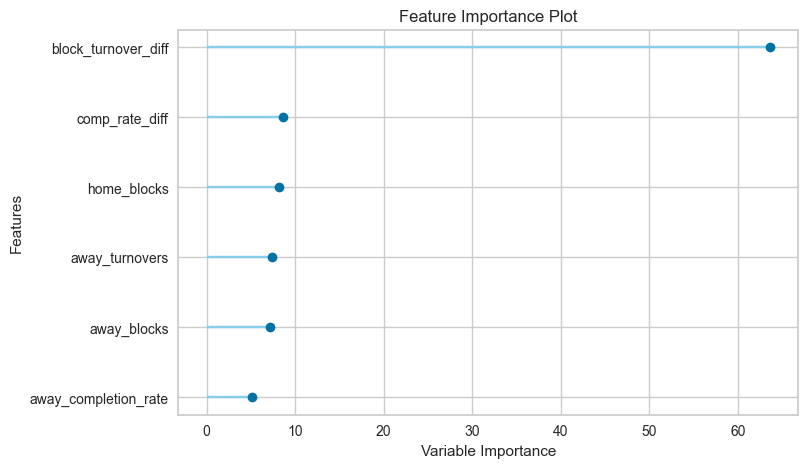

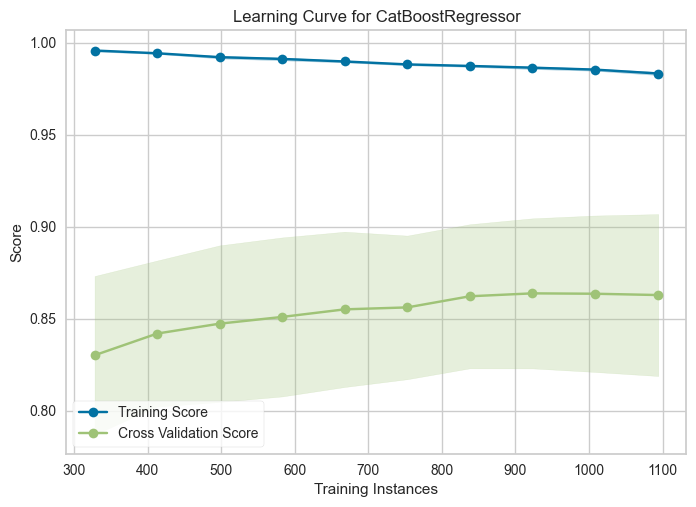

In [31]:
# evaluate best model
for plot_type in ['residuals', 'error', 'feature', 'learning']:
    try:
        plot_model(best, plot=plot_type)
    except:
        print(plot_type, 'plot not available for model')

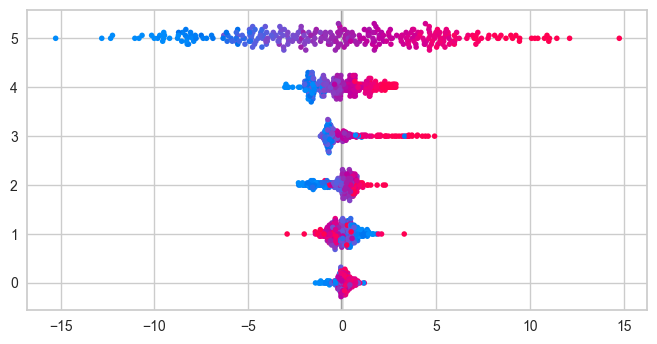

In [37]:
try: 
    interpret_model(best) 
except: 
    pass

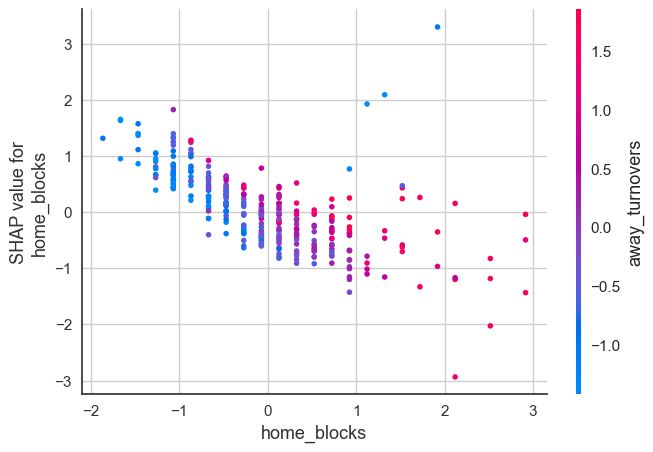

In [33]:
interpret_model(best, 'correlation')

In [34]:
interpret_model(best, 'reason')

### Regression Pt 2 - Tuning

**Conclusion**: **Use pycaret for model selection, tune manually with RandomizedSearchCV. Can include manually tuned models in model list to then `compare_models`**

- models
  - *all data*: random forest, extra trees, gradient boosting, XGB, CatBoost, Huber
  - *select 6 features*: linear regression, ridge least angle, bayesian ridge, kNN
- tuning output
  - **select 6 features** no improvement for models, only one changed with tuning
    - only knn parameters changed with tuning. no changes to metrics
  - **all data** no improvement for models, no effects for few that changed with tuning
    - tuning worse than original: extra trees, light GBM, catboost

#### Linear (mostly) Models - select 6 features

In [42]:
s3 = setup(data.drop(columns='home_win'), target = 'home_margin', session_id = 42,  train_size=0.8,
          feature_selection=True, feature_selection_method='univariate', n_features_to_select=6)

In [43]:
models = []
for est in ['lr', 'ridge', 'lar', 'br', 'knn']:
    models.append(create_model(est))

In [49]:
for model in models:
    print(model.__class__.__name__)
    model = tune_model(model)

LinearRegression


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Ridge


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Lars


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
BayesianRidge


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
KNeighborsRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [50]:
compare_models(include=models)

KNeighborsRegressor(n_jobs=-1)

In [51]:
results['select 6 tuned'] = pull()

In [52]:
# manual vmax for background gradients due to extremely (bad) LAR results for all data, normalized

model_names = results['select 6 tuned'].Model

for key,val in results.items():
    if key not in ['select 6 tuned', 'all data, zscore normalized', 'select 6, no scaling']:
        continue
    
    print(key)
    val = val[val.Model.isin(model_names)]
    display(val.sort_values('R2',ascending=False).style\
            .background_gradient(subset=['R2'], cmap='viridis', vmin=np.percentile(val.R2, 0.5))
            .background_gradient(subset=['MAE'], cmap='viridis_r', vmax=5)
            .background_gradient(subset=['RMSE'], cmap='viridis_r', vmax=7)
            .background_gradient(subset=['MAPE'], cmap='viridis_r', vmax=1)
            .highlight_max(subset=['R2'],  props='font-weight:bold')
            .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))
    print('\n')

select 6, no scaling




all data, zscore normalized




select 6 tuned


#### Ensemble (mostly) Models - all data

In [53]:
s1 = setup(data.drop(columns='home_win'), target = 'home_margin', session_id = 42,
           train_size=0.8)

In [54]:
models = []
for est in ['rf','et', 'gbr', 'xgboost', 'lightgbm', 'catboost', 'huber']:
    models.append(create_model(est))

In [55]:
for model in models:
    print(model.__class__.__name__)
    model = tune_model(model)
    print('\n\n')

RandomForestRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits



ExtraTreesRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



GradientBoostingRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits



XGBRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits



LGBMRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



CatBoostRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



HuberRegressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits





In [56]:
compare_models(include=models)

In [57]:
results['all data tuned'] = pull()

In [ ]:
extra trees, light GBM, catboost

In [60]:
# manual vmax for background gradients due to extremely (bad) LAR results for all data, normalized

model_names = results['all data tuned'].Model

print('models with hyperparameter tuning: rf, gb, xgboost, huber\n\n')

for key,val in results.items():
    if key not in ['all data tuned', 'all data, no scaling']:
        continue
    
    print(key)
    val = val[val.Model.isin(model_names)]
    display(val.sort_values('R2',ascending=False).style\
            .background_gradient(subset=['R2'], cmap='viridis', vmin=np.percentile(val.R2, 0.5))
            .background_gradient(subset=['MAE'], cmap='viridis_r', vmax=5)
            .background_gradient(subset=['RMSE'], cmap='viridis_r', vmax=7)
            .background_gradient(subset=['MAPE'], cmap='viridis_r', vmax=1)
            .highlight_max(subset=['R2'],  props='font-weight:bold')
            .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))
    print('\n')

models with hyperparameter tuning: rf, gb, xgboost, huber


all data, no scaling




all data tuned


---

### Classification
`home_win`

In [6]:
classification_results = {}

#### Results
 - *simple Logistic Regression performs well, should keep as baseline*
 - normalizing does not help best models (rf, et, gb's)
   - may help simple LogReg
 - feature selection does not help best models (rf, et, gb's)
   - brings KNN into relevance, some of best overall scores
     - 6 better than 8 features for kNN. could test more
     - unscaled data better
   - improves lda

In [45]:


for key,val in classification_results.items():
    print(key)
    #val = val[val.index.isin(['lr','ridge',])]
    display(val.sort_values('Accuracy',ascending=False).style\
            .background_gradient(subset=['Accuracy','AUC','F1'], cmap='viridis', vmin=0.8)
            .highlight_max(subset=['Accuracy','AUC','F1'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))

all data, no treatment


all data, zscore normalized


select 6 features


select 8 features


select 6 features, zscore normalized


In [133]:
for key,val in classification_results.items():
    print(key)
    display(val.sort_values('Accuracy',ascending=False).round(3))
    # plt.violinplot(val['F1'], vert=False)
    # plt.boxplot(val['F1'], vert=False)
    # plt.title(f'{key} F1 distribution')
    plt.show()

all data, no treatment


Model  Accuracy    AUC  Recall  Prec.  \
rf               Random Forest Classifier     0.924  0.979   0.933  0.935   
et                 Extra Trees Classifier     0.923  0.978   0.930  0.936   
lr                    Logistic Regression     0.920  0.972   0.933  0.929   
gbc          Gradient Boosting Classifier     0.916  0.973   0.931  0.925   
lightgbm  Light Gradient Boosting Machine     0.915  0.974   0.931  0.923   
ridge                    Ridge Classifier     0.914  0.000   0.928  0.922   
lda          Linear Discriminant Analysis     0.909  0.970   0.920  0.922   
dt               Decision Tree Classifier     0.896  0.894   0.907  0.913   
ada                  Ada Boost Classifier     0.895  0.959   0.915  0.904   
nb                            Naive Bayes     0.884  0.952   0.886  0.911   
qda       Quadratic Discriminant Analysis     0.848  0.892   0.897  0.860   
knn                K Neighbors Classifier     0.817  0.892   0.853  0.833   
svm                   SVM - Linear Kernel     0.805  0.000   0.830  0.872   
dummy                    Dummy Classifier     0.576  0.500   1.000  0.576   

             F1  Kappa    MCC  TT (Sec)  
rf        0.934  0.844  0.845     0.055  
et        0.933  0.842  0.843     0.047  
lr        0.931  0.836  0.837     0.486  
gbc       0.928  0.828  0.829     0.053  
lightgbm  0.927  0.826  0.827     0.087  
ridge     0.925  0.823  0.823     0.009  
lda       0.921  0.813  0.814     0.008  
dt        0.909  0.786  0.788     0.008  
ada       0.909  0.784  0.785     0.028  
nb        0.898  0.764  0.765     0.008  
qda       0.874  0.682  0.693     0.009  
knn       0.842  0.623  0.624     0.254  
svm       0.818  0.600  0.652     0.010  
dummy     0.731  0.000  0.000     0.007

all data, zscore normalized


Model  Accuracy    AUC  Recall  Prec.  \
et                 Extra Trees Classifier     0.923  0.978   0.930  0.936   
rf               Random Forest Classifier     0.923  0.979   0.933  0.934   
lr                    Logistic Regression     0.920  0.972   0.931  0.931   
gbc          Gradient Boosting Classifier     0.916  0.973   0.931  0.925   
lightgbm  Light Gradient Boosting Machine     0.914  0.975   0.931  0.922   
ridge                    Ridge Classifier     0.913  0.000   0.925  0.924   
lda          Linear Discriminant Analysis     0.909  0.970   0.920  0.922   
svm                   SVM - Linear Kernel     0.903  0.000   0.920  0.916   
knn                K Neighbors Classifier     0.900  0.957   0.920  0.908   
dt               Decision Tree Classifier     0.895  0.893   0.905  0.913   
ada                  Ada Boost Classifier     0.895  0.959   0.915  0.904   
nb                            Naive Bayes     0.883  0.952   0.884  0.911   
qda       Quadratic Discriminant Analysis     0.880  0.924   0.871  0.918   
dummy                    Dummy Classifier     0.576  0.500   1.000  0.576   

             F1  Kappa    MCC  TT (Sec)  
et        0.933  0.842  0.843     0.048  
rf        0.933  0.842  0.843     0.059  
lr        0.931  0.836  0.837     0.467  
gbc       0.928  0.828  0.829     0.052  
lightgbm  0.926  0.824  0.825     0.079  
ridge     0.924  0.821  0.822     0.010  
lda       0.921  0.813  0.814     0.009  
svm       0.917  0.801  0.805     0.010  
knn       0.914  0.796  0.796     0.258  
dt        0.908  0.785  0.786     0.010  
ada       0.909  0.784  0.785     0.031  
nb        0.897  0.763  0.764     0.010  
qda       0.893  0.756  0.760     0.013  
dummy     0.731  0.000  0.000     0.009

select 6 features


Model  Accuracy    AUC  Recall  Prec.  \
et                 Extra Trees Classifier     0.930  0.977   0.944  0.934   
knn                K Neighbors Classifier     0.928  0.964   0.941  0.934   
rf               Random Forest Classifier     0.924  0.977   0.930  0.938   
lr                    Logistic Regression     0.923  0.972   0.941  0.927   
lightgbm  Light Gradient Boosting Machine     0.921  0.973   0.938  0.926   
gbc          Gradient Boosting Classifier     0.918  0.970   0.935  0.925   
ridge                    Ridge Classifier     0.918  0.000   0.933  0.926   
lda          Linear Discriminant Analysis     0.918  0.971   0.935  0.924   
ada                  Ada Boost Classifier     0.900  0.959   0.920  0.907   
dt               Decision Tree Classifier     0.896  0.892   0.913  0.906   
nb                            Naive Bayes     0.893  0.956   0.889  0.923   
svm                   SVM - Linear Kernel     0.872  0.000   0.889  0.905   
qda       Quadratic Discriminant Analysis     0.862  0.928   0.866  0.896   
dummy                    Dummy Classifier     0.576  0.500   1.000  0.576   

             F1  Kappa    MCC  TT (Sec)  
et        0.939  0.856  0.856     0.047  
knn       0.938  0.852  0.852     0.016  
rf        0.934  0.844  0.845     0.056  
lr        0.934  0.842  0.843     0.013  
lightgbm  0.932  0.838  0.838     0.062  
gbc       0.930  0.832  0.833     0.036  
ridge     0.929  0.832  0.833     0.011  
lda       0.929  0.832  0.833     0.009  
ada       0.913  0.794  0.794     0.027  
dt        0.910  0.786  0.787     0.011  
nb        0.905  0.782  0.784     0.009  
svm       0.885  0.739  0.761     0.009  
qda       0.878  0.718  0.724     0.010  
dummy     0.731  0.000  0.000     0.009

select 8 features


Model  Accuracy    AUC  Recall  Prec.  \
knn                K Neighbors Classifier     0.927  0.965   0.940  0.934   
rf               Random Forest Classifier     0.924  0.976   0.933  0.935   
lr                    Logistic Regression     0.923  0.972   0.941  0.927   
et                 Extra Trees Classifier     0.922  0.977   0.933  0.932   
lda          Linear Discriminant Analysis     0.920  0.971   0.941  0.922   
lightgbm  Light Gradient Boosting Machine     0.920  0.971   0.936  0.926   
ridge                    Ridge Classifier     0.918  0.000   0.935  0.924   
gbc          Gradient Boosting Classifier     0.917  0.970   0.931  0.926   
ada                  Ada Boost Classifier     0.900  0.956   0.918  0.910   
nb                            Naive Bayes     0.888  0.952   0.887  0.916   
dt               Decision Tree Classifier     0.886  0.883   0.902  0.901   
svm                   SVM - Linear Kernel     0.882  0.000   0.863  0.940   
qda       Quadratic Discriminant Analysis     0.849  0.915   0.881  0.864   
dummy                    Dummy Classifier     0.576  0.500   1.000  0.576   

             F1  Kappa    MCC  TT (Sec)  
knn       0.937  0.850  0.850     0.016  
rf        0.934  0.844  0.844     0.056  
lr        0.934  0.842  0.843     0.011  
et        0.932  0.840  0.841     0.048  
lda       0.931  0.836  0.837     0.009  
lightgbm  0.931  0.836  0.837     0.067  
ridge     0.929  0.832  0.833     0.009  
gbc       0.929  0.830  0.831     0.041  
ada       0.914  0.796  0.796     0.030  
nb        0.901  0.772  0.773     0.010  
dt        0.901  0.767  0.768     0.010  
svm       0.891  0.761  0.780     0.010  
qda       0.870  0.689  0.694     0.009  
dummy     0.731  0.000  0.000     0.008

select 6 features, zscore normalized


Model  Accuracy    AUC  Recall  Prec.  \
et                 Extra Trees Classifier     0.930  0.977   0.944  0.934   
rf               Random Forest Classifier     0.923  0.977   0.928  0.938   
lr                    Logistic Regression     0.921  0.971   0.938  0.927   
knn                K Neighbors Classifier     0.919  0.956   0.930  0.930   
gbc          Gradient Boosting Classifier     0.918  0.970   0.935  0.925   
ridge                    Ridge Classifier     0.918  0.000   0.936  0.923   
lda          Linear Discriminant Analysis     0.918  0.971   0.935  0.924   
lightgbm  Light Gradient Boosting Machine     0.916  0.973   0.930  0.926   
svm                   SVM - Linear Kernel     0.915  0.000   0.928  0.927   
ada                  Ada Boost Classifier     0.900  0.959   0.920  0.907   
dt               Decision Tree Classifier     0.896  0.892   0.913  0.906   
nb                            Naive Bayes     0.893  0.956   0.889  0.923   
qda       Quadratic Discriminant Analysis     0.875  0.930   0.883  0.904   
dummy                    Dummy Classifier     0.576  0.500   1.000  0.576   

             F1  Kappa    MCC  TT (Sec)  
et        0.939  0.856  0.856     0.049  
rf        0.933  0.842  0.843     0.055  
lr        0.932  0.838  0.839     0.011  
knn       0.930  0.834  0.835     0.020  
gbc       0.930  0.832  0.833     0.034  
ridge     0.929  0.832  0.833     0.010  
lda       0.929  0.832  0.833     0.010  
lightgbm  0.928  0.829  0.830     0.064  
svm       0.927  0.827  0.829     0.011  
ada       0.913  0.794  0.794     0.027  
dt        0.910  0.786  0.786     0.010  
nb        0.905  0.782  0.784     0.011  
qda       0.891  0.744  0.749     0.010  
dummy     0.731  0.000  0.000     0.010

#### Model Selection
- experiments:
  - all data, scaled data, select 6 or 8 features?

In [80]:
help(plot_model)

Help on function plot_model in module pycaret.classification.functional:

plot_model(estimator, plot: str = 'auc', scale: float = 1, save: bool = False, fold: Union[int, Any, NoneType] = None, fit_kwargs: Optional[dict] = None, plot_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, verbose: bool = True, display_format: Optional[str] = None) -> Optional[str]
    This function analyzes the performance of a trained model on holdout set.
    It may require re-training the model in certain cases.
    
    Example
    -------
    >>> from pycaret.datasets import get_data
    >>> juice = get_data('juice')
    >>> from pycaret.classification import *
    >>> exp_name = setup(data = juice,  target = 'Purchase')
    >>> lr = create_model('lr')
    >>> plot_model(lr, plot = 'auc')
    
    
    estimator: scikit-learn compatible object
        Trained model object
    
    
    plot: str, default = 'auc'
        List of available plots (ID - Name):
    
        * 'pipeline'

##### all data

In [7]:
from pycaret.classification import *
c1 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8)

In [8]:
# compare baseline models
best = compare_models()

In [9]:
classification_results['all data, no treatment'] = pull()

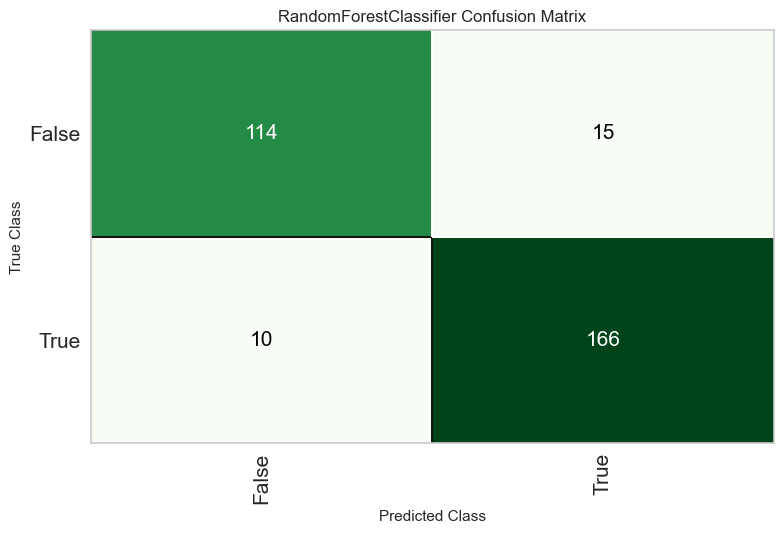

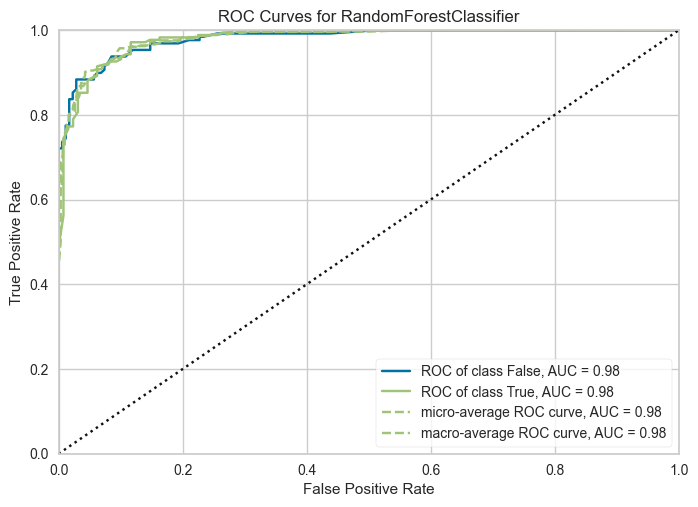

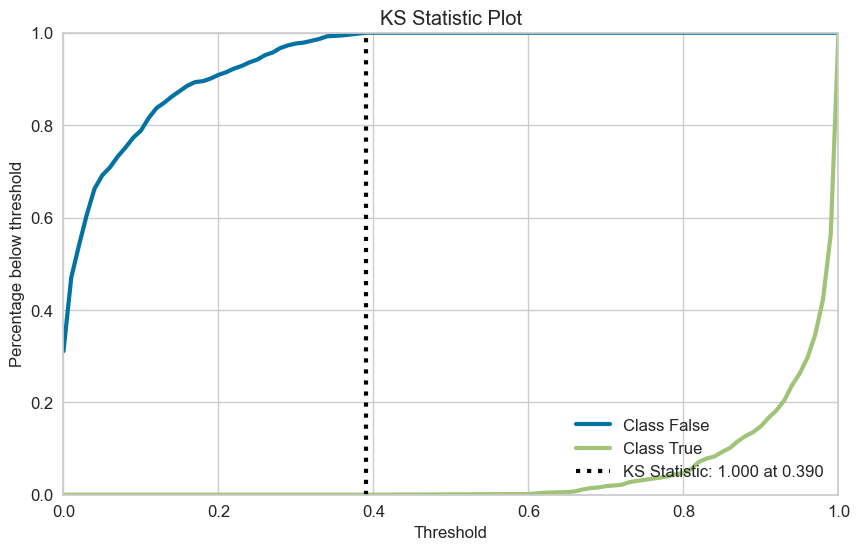

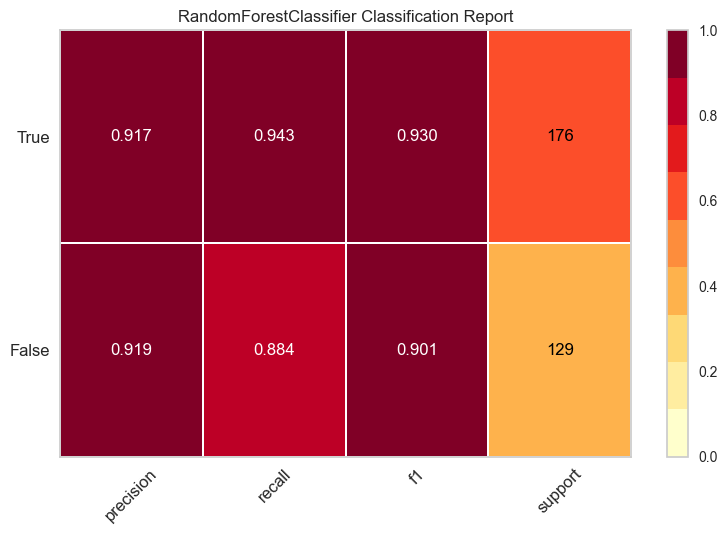

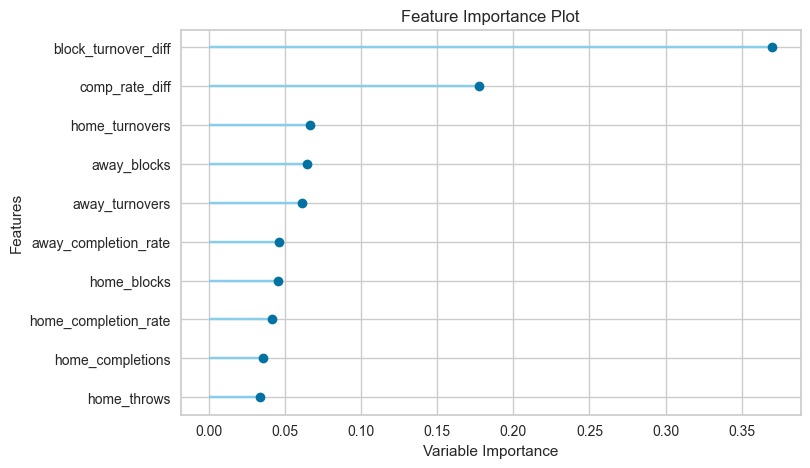

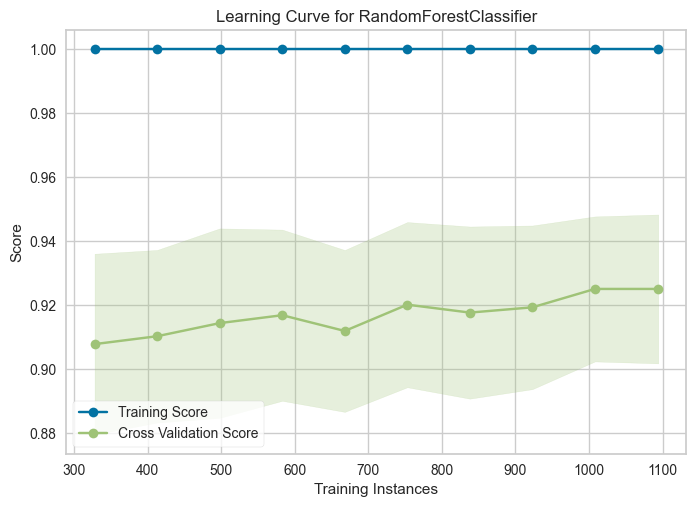

In [10]:
# evaluate best model
for plot_type in ['confusion_matrix', 'auc','ks', 'class_report', 'feature', 'learning']:
    try:
        plot_model(best, plot=plot_type)
    except:
        print(plot_type, 'plot not available for model')

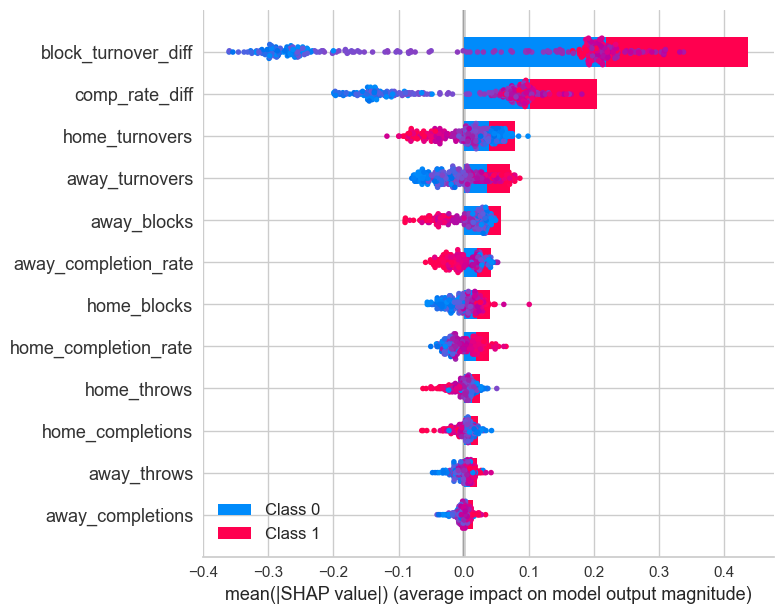

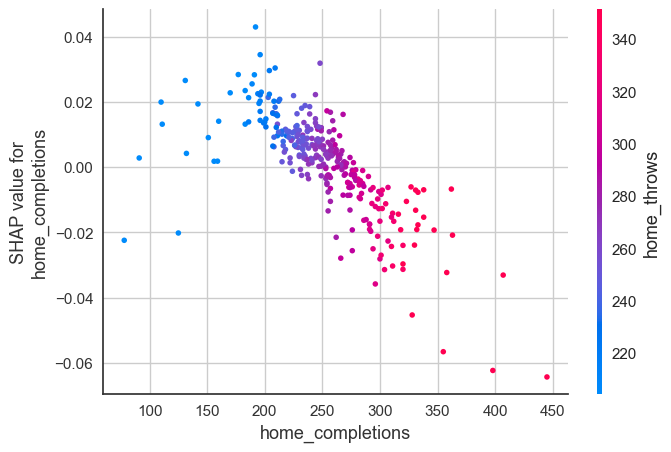

12it [00:00, 21.91it/s]


In [17]:
# evaluate best model
for plot_type in ['summary', 'correlation', 'reason', 'pdp','msa','pfi']:
    try:
        interpret_model(best, plot=plot_type)
    except:
        print(plot_type, 'plot not available for model')

---
##### normalized data

In [19]:
c2 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
           normalize=True)

In [20]:
# compare baseline models
best = compare_models()

In [21]:
classification_results['all data, zscore normalized'] = pull()

---
##### feature selection

In [22]:
c3 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
           feature_selection=True, feature_selection_method='univariate', n_features_to_select=6)

In [23]:
# compare baseline models
best = compare_models()

In [25]:
classification_results['select 6 features'] = pull()

In [26]:
c3b = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
           feature_selection=True, feature_selection_method='univariate', n_features_to_select=8)
# compare baseline models
best = compare_models()

In [27]:
classification_results['select 8 features'] = pull()

---
##### feature selection + normalization

In [28]:
c4 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
           feature_selection=True, feature_selection_method='univariate', n_features_to_select=6,
           normalize=True)

In [29]:
# compare baseline models
best = compare_models()

In [30]:
classification_results['select 6 features, zscore normalized'] = pull()

### Classification Pt 2 - Tuning

**Even when tuning finds "better" hyperparameters, tuned model metrics are same as untuned model's**

- all data, no treatment:
  - rf, et, gbc, xgboost, lightgbm
  - *changed with tuning*: gbc, lightgbm, lr
    - no improvements to metrics with tuning!
- select 6 features, no treatment:
  - kNN
  - both kNN and LR changed with tuning, no effect on metrics
- select 6 features, zscore normalize:
  - lda, nb
  - *lda did not change with tuning*
  - no effect on metrics!

#### All data, no treatment

In [84]:
c1 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
          verbose=False)

In [85]:
models = []
for est in ['rf', 'et', 'gbc', 'xgboost', 'lightgbm', 'lr', 'ridge']:
    models.append(create_model(est, verbose=False))

In [86]:
for model in models:
    print(model.__class__.__name__)
    model = tune_model(model)
    print('\n\n')

RandomForestClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



ExtraTreesClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



GradientBoostingClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits



XGBClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



LGBMClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits



LogisticRegression


Fitting 10 folds for each of 10 candidates, totalling 100 fits



RidgeClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits





In [87]:
compare_models(include=models)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [88]:
classification_results['all data tuned'] = pull()

In [58]:
classification_results.keys()

dict_keys(['all data, no treatment', 'all data, zscore normalized', 'select 6 features', 'select 8 features', 'select 6 features, zscore normalized', 'all data tuned'])

In [89]:
# manual vmax for background gradients due to extremely (bad) LAR results for all data, normalized

model_names = classification_results['all data tuned'].Model

for key,val in classification_results.items():
    if key not in ['all data tuned','all data, no treatment']:
        continue
    
    print(key)
    val = val[val.Model.isin(model_names)]
    display(val.sort_values('Accuracy',ascending=False).style\
            .background_gradient(subset=['Accuracy','AUC','F1'], cmap='viridis', vmin=0.8)
            .highlight_max(subset=['Accuracy','AUC','F1'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))
    print('\n')

all data, no treatment




all data tuned


#### Select 6, unscaled

In [71]:
c3 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
           feature_selection=True, feature_selection_method='univariate', n_features_to_select=6)

In [72]:
models = []
for est in ['knn', 'lr']:
    models.append(create_model(est, verbose=False))

In [73]:
for model in models:
    print(model.__class__.__name__)
    model = tune_model(model)
    print('\n\n')

KNeighborsClassifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits



LogisticRegression


Fitting 10 folds for each of 10 candidates, totalling 100 fits





In [74]:
compare_models(include=models)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [75]:
classification_results['select 6 tuned'] = pull()

In [78]:
# manual vmax for background gradients due to extremely (bad) LAR results for all data, normalized

model_names = classification_results['select 6 tuned'].Model

for key,val in classification_results.items():
    if key not in ['select 6 tuned', 'select 6 features',]:
        continue
    
    print(key)
    val = val[val.Model.isin(model_names)]
    display(val.sort_values('Accuracy',ascending=False).style\
            .background_gradient(subset=['Accuracy','AUC','F1'], cmap='viridis', vmin=0.8)
            .highlight_max(subset=['Accuracy','AUC','F1'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))
    print('\n')

select 6 features




select 6 tuned


#### Select 6, scaled

In [ ]:
c4 = setup(data.drop(columns='home_margin'), target = 'home_win', session_id = 42, train_size=0.8,
           feature_selection=True, feature_selection_method='univariate', n_features_to_select=6,
           normalize=True)

In [79]:
models = []
for est in ['lda', 'nb','lr']:
    models.append(create_model(est, verbose=False))

In [80]:
for model in models:
    print(model.__class__.__name__)
    model = tune_model(model)
    print('\n\n')

LinearDiscriminantAnalysis


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).



GaussianNB


Fitting 10 folds for each of 10 candidates, totalling 100 fits



LogisticRegression


Fitting 10 folds for each of 10 candidates, totalling 100 fits





In [81]:
compare_models(include=models)

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)

In [82]:
classification_results['select 6 normalized tuned'] = pull()

In [83]:
# manual vmax for background gradients due to extremely (bad) LAR results for all data, normalized

model_names = classification_results['select 6 normalized tuned'].Model

for key,val in classification_results.items():
    if key not in ['select 6 normalized tuned','select 6 features, zscore normalized', 'select 6 features', ]:
        continue
    
    print(key)
    val = val[val.Model.isin(model_names)]
    display(val.sort_values('Accuracy',ascending=False).style\
            .background_gradient(subset=['Accuracy','AUC','F1'], cmap='viridis', vmin=0.8)
            .highlight_max(subset=['Accuracy','AUC','F1'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))
    print('\n')

select 6 features




select 6 features, zscore normalized




select 6 normalized tuned
